In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd, pinv

In [2]:
class Components:
    def __init__(self,u, v, resistance=0 , current_source=0, voltage_source=0):
        self.edge = (u,v)
        self.resistance = resistance 
        self.current_source = current_source
        self.voltage_source = voltage_source
    def __repr__(self):
        return f"Components(resistance={self.resistance},current_source={self.current_source},voltage_source={self.voltage_source})"
        

In [3]:
components_list = (Components(1,2,4,0,0),Components(2,3,4,0,0),Components(1,3,0,0,8))

node_list = [comp.edge for comp in components_list]
Resistance = []
Current_source = []
Voltage_source = []

graph = nx.DiGraph()
graph.add_edges_from(node_list)
pos = nx.planar_layout(graph)

In [4]:

for edge in graph.edges:
    for comp in components_list:
        if comp.edge == edge:
            Resistance.append(comp.resistance)
            Current_source.append(comp.current_source)
            Voltage_source.append(comp.voltage_source)
    
Resistance = np.array(Resistance)
Current_source = np.array(Current_source)
Voltage_source = np.array(Voltage_source)


In [5]:
non_directed_graph = graph.to_undirected()
tree_graph = nx.minimum_spanning_tree(non_directed_graph)

directed_tree_graph = nx.DiGraph()
directed_tree_graph.add_edges_from(tree_graph.edges)
cotree_edges = graph.edges() - directed_tree_graph.edges()

cotree_graph = nx.DiGraph()
cotree_graph.add_edges_from(cotree_edges)

In [6]:
directed_tree_graph.edges

OutEdgeView([(1, 2), (1, 3)])

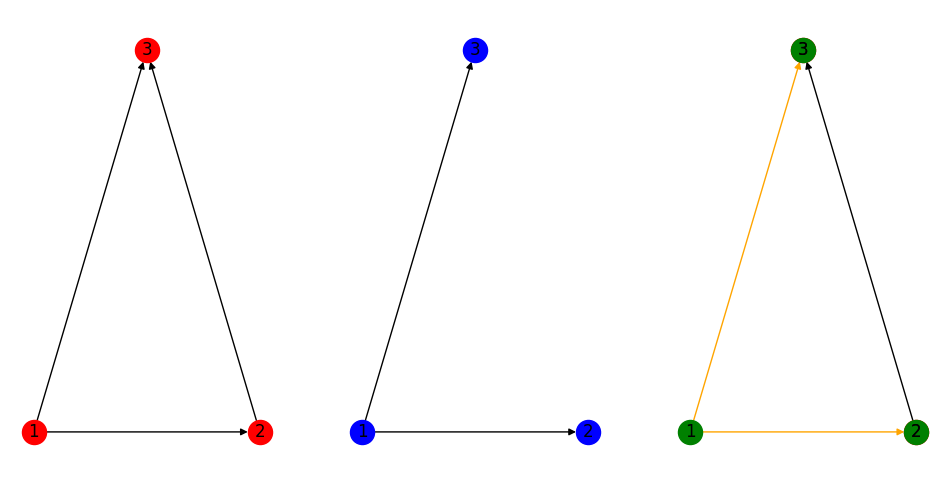

In [7]:
fig, ax = plt.subplots(1, 3, figsize= (12,6))

nx.draw(graph, with_labels = True, pos = pos, node_color = 'r', ax=ax[0])

nx.draw(directed_tree_graph, with_labels = True, pos=pos, ax=ax[1], node_color = 'blue')

nx.draw(cotree_graph, with_labels = True, pos=pos, ax= ax[2], node_color = 'red')
nx.draw(directed_tree_graph, with_labels = True, pos= pos,  ax= ax[2], node_color = 'green', edge_color = 'orange')

# plt.savefig("combined.png", format="png", dpi=300)
plt.show()

In [8]:
print(cotree_graph.edges(), tree_graph.edges(), graph.edges())

[(2, 3)] [(1, 2), (1, 3)] [(1, 2), (1, 3), (2, 3)]


In [9]:
Bf = np.zeros((len(cotree_edges), len(graph.edges())), dtype=int)
Cf = np.zeros((len(tree_graph.edges()), len(graph.edges())), dtype=int)
edge_index = {edge: i for i, edge in enumerate(graph.edges())}


for i,edge in enumerate(cotree_graph.edges):
    tree_copy = directed_tree_graph.copy()
    tree_copy.add_edge(*edge)
    cycle = list(nx.find_cycle(tree_copy, orientation="ignore"))

    co_tree_orient = [i[2] for i in cycle if (i[0],i[1]) == edge][0]
    for (start, end, orientation) in cycle:
        sign = 1 if orientation == co_tree_orient else -1
        Bf[i, edge_index[(start, end)]] = sign

print(Bf)

[[ 1 -1  1]]


In [ ]:

for i, edge in enumerate(directed_tree_graph.edges()):
    T_minus_edge = tree_graph.copy()
    T_minus_edge.remove_edge(*edge)

    components = list(nx.connected_components(T_minus_edge))
    component_map = {node: idx for idx, component in enumerate(components) for node in component}
    for start, end in graph.edges():
        if component_map[start] > component_map[end]:
            sign = -1
            if start < end:
                Cf[i, edge_index[(start, end)]] = sign
        elif component_map[start] < component_map[end]:
            sign = 1
            if start < end:
                Cf[i, edge_index[(start, end)]] = sign


print(Cf)

[[ 1  0 -1]
 [ 0  1  1]]


In [11]:
Is = Current_source.T
Vs = Voltage_source.T
R = np.diag(Resistance)

In [12]:
B = Bf
Z=np.linalg.inv(np.dot(B,np.dot(R,B.T)))
Loop_current = -np.dot(Z,np.dot(B,np.dot(R,Is)))-np.dot(Z,np.dot(B,Vs))
Branch_current=np.dot(B.T,Loop_current)
Impedence_current = Branch_current + Is
for count, edge in enumerate(graph.edges()):
    print(edge, Impedence_current[count])

(1, 2) 1.0
(1, 3) -1.0
(2, 3) 1.0
